In [183]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from pathlib import Path
from tqdm import tqdm

In [185]:
from src.twr import time_weighted_return_annualized
from src.mwr import money_weighted_return_annualized, theoretical_mwr_annualized, theoretical_mwr_annualized_with_inverted_flows, _estimate_flows

## Minimal working example: TWR vs MWR

In [186]:
n = pd.Series([1,1.5,1.2], index=[pd.to_datetime(f'{y}-01-01') for y in (2012,2013,2014)])
a = pd.Series([100,500,40], index=[pd.to_datetime(f'{y}-01-01') for y in (2012,2013,2014)])
n

2012-01-01    1.0
2013-01-01    1.5
2014-01-01    1.2
dtype: float64

In [187]:
time_weighted_return_annualized(n)

0.09530851391195339

In [188]:
money_weighted_return_annualized(n, a)

-0.09242237763043791

# Load data

In [189]:
PATH = Path.cwd().parent / 'data'

In [190]:
# DataFrames where COLUMNS are FUNDS_NAMES and INDEX are DATES
navs = pd.read_csv(PATH / 'NAVs.csv', index_col=0, parse_dates=True)
aums = pd.read_csv(PATH / 'AUMs.csv', index_col=0, parse_dates=True)

assert navs.columns.to_list() == aums.columns.to_list()

# Calculate returns

In [191]:
SYMBOLS = navs.columns
FREQ = 'BM'
CLIP = 0.3

In [192]:
df = pd.DataFrame(index=SYMBOLS, columns=['TWR', 'MWR', 'MWR_INV'], dtype=float)

for s in tqdm(SYMBOLS):
    nav = navs[s].dropna()
    aum = aums[s].dropna()
    
    idxs = nav.index.intersection(aum.index)
    nav = nav.reindex(idxs).asfreq(FREQ, method='ffill')
    aum = aum.reindex(idxs).asfreq(FREQ, method='ffill')

    # We need at least 2 prices, for calculating a return
    if len(nav) > 1:
        df.loc[s, 'TWR'] = time_weighted_return_annualized(nav=nav)
        df.loc[s, 'MWR'] = theoretical_mwr_annualized(nav=nav, aum=aum, max_flows_weight=CLIP)
        df.loc[s, 'MWR_INV'] = theoretical_mwr_annualized_with_inverted_flows(nav=nav, aum=aum, max_flows_weight=CLIP)

100%|██████████| 3/3 [00:00<00:00, 26.63it/s]


# Analysis

In [193]:
df['spread_MWR'] = df['MWR'] - df['TWR']
df['spread_MWR_INV'] = df['MWR_INV'] - df['TWR']

In [194]:
df.applymap("{:,.2%}".format)

,TWR,MWR,MWR_INV,spread_MWR,spread_MWR_INV
Fund_A,10.45%,3.24%,16.42%,-7.22%,5.96%
Fund_B,12.72%,11.70%,13.86%,-1.01%,1.14%
Fund_C,14.26%,15.04%,12.91%,0.78%,-1.36%


In [195]:
df.describe()

,TWR,MWR,MWR_INV,spread_MWR,spread_MWR_INV
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.124791,0.099943,0.143940,-0.024848,0.019148
std,0.019167,0.060840,0.018167,0.041936,0.037229
min,0.104537,0.032381,0.129055,-0.072156,-0.013590
25%,0.115864,0.074715,0.133818,-0.041149,-0.001100
50%,0.127191,0.117049,0.138581,-0.010142,0.011390
75%,0.134918,0.133724,0.151382,-0.001194,0.035518
max,0.142645,0.150399,0.164183,0.007754,0.059646


# Graphical analyis

In [196]:
FUND_NAME = 'Fund_A'
FREQ = 'BM'

In [197]:
__nav = navs[FUND_NAME]
__aum = aums[FUND_NAME]

data = pd.concat([__nav, __aum], axis=1)
data.columns = ['nav', 'aum']

data = data.dropna().asfreq(FREQ, method='ffill')

nav = data['nav']
aum = data['aum']

In [198]:
flows_amount, flows_weight = _estimate_flows(nav=nav, aum=aum)

In [199]:
time_weighted_return_annualized(nav=nav)

0.10453717489453362

In [200]:
money_weighted_return_annualized(nav=nav, aum=aum)

0.03236299321825076

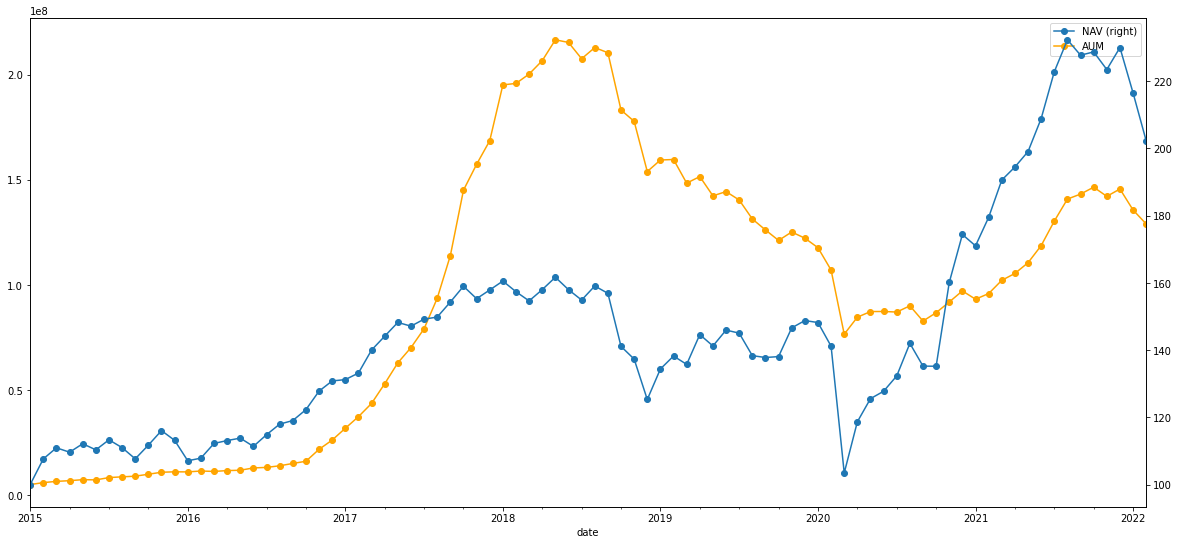

In [201]:
ax = nav.to_frame('NAV').plot(secondary_y=True, style='-o', figsize=(20,9))
ax = aum.to_frame('AUM').plot(ax=ax, style='-o', color='orange')

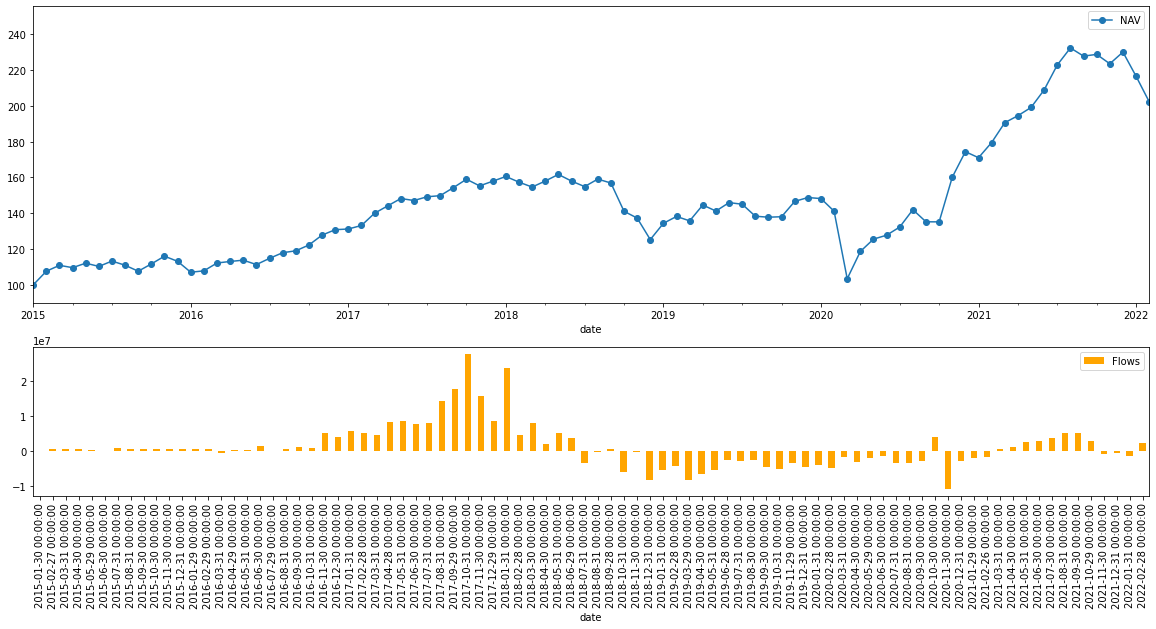

In [202]:
fig, axs = plt.subplots(nrows=2, sharex=False, gridspec_kw={'height_ratios': [2, 1]}, figsize=(20,9))
                                                        
ax = nav.to_frame('NAV').plot(ax=axs[0], style='-o', ylim=(nav.min()*0.9, nav.max()*1.1))
ax = flows_amount.to_frame('Flows').plot.bar(ax=axs[1], color='orange')

<AxesSubplot:title={'center':'NAV returns vs AUM "returns"'}, xlabel='date'>

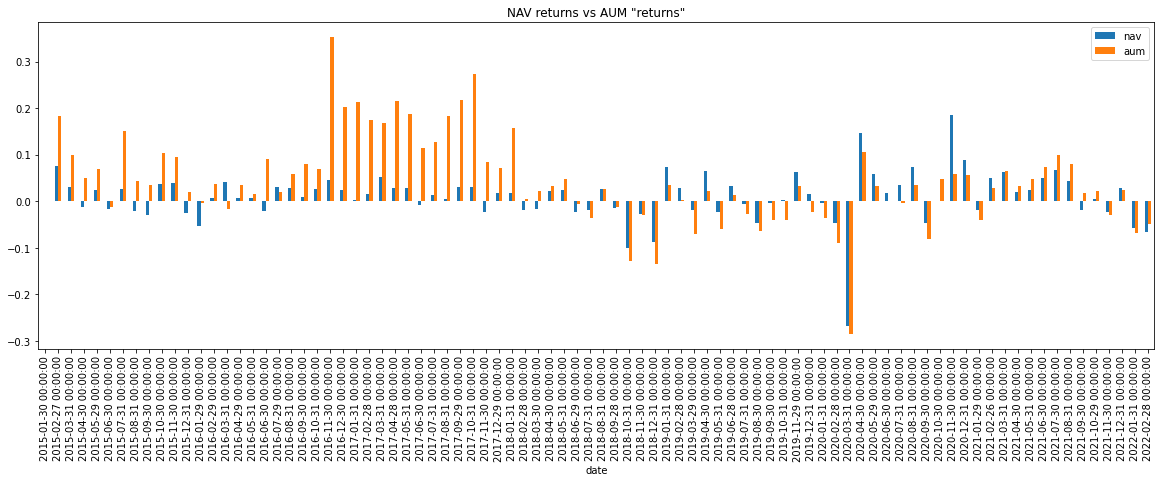

In [203]:
data.pct_change().plot.bar(figsize=(20,6), title='NAV returns vs AUM "returns"')

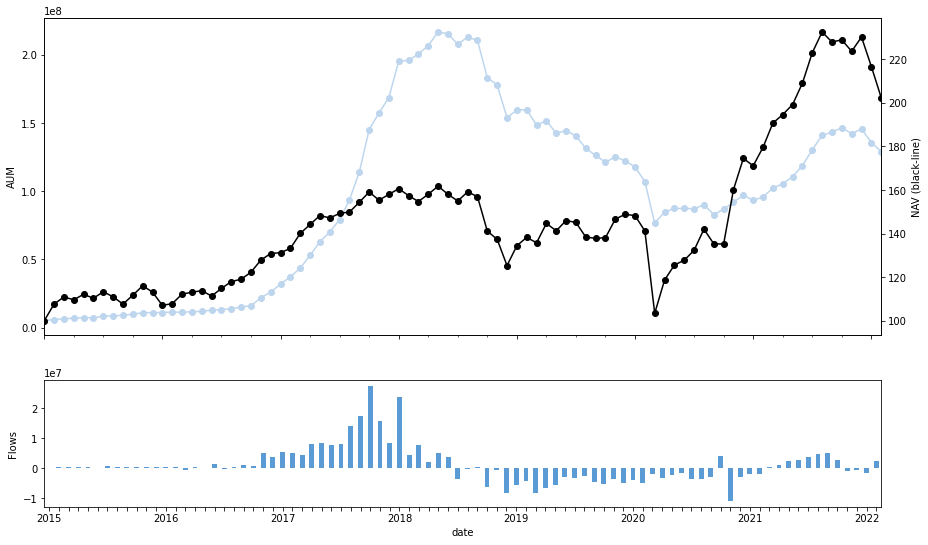

In [205]:
fig, axs = plt.subplots(nrows=2, sharex=False, gridspec_kw={'height_ratios': [2.5, 1]}, figsize=(15,9))
                                                        
ax = nav.to_frame('NAV').plot(ax=axs[0], style='-o', color='black', secondary_y=True, legend=False)  #ylim=(nav.min()*0.9, nav.max()*1.1)
plt.ylabel('NAV (black-line)')
ax = aum.to_frame('AUM').plot(ax=axs[0], style='-o', color='#bdd6ee', ylabel='AUM', legend=False)
ax = flows_amount.to_frame('Flows').plot.bar(ax=axs[1], color='#5b9bd5', sharex=True, rot=0, ylabel='Flows', legend=False)

def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    if label.month_name()[:3] == 'Jan':
        month = f'{label.year}'
    else:
        month = ''
    return month

# Note that we specify rot here
ax = ax.set_xticklabels(map(line_format, flows_amount.index))